# RMSProp
RMSprop 是由 Geoff Hinton 在他 Coursera 课程中提出的一种适应性学习率方法，至今仍未被公开发表。前面我们提到了 Adagrad 算法有一个问题，就是学习率分母上的变量 s 不断被累加增大，最后会导致学习率除以一个比较大的数之后变得非常小，这不利于我们找到最后的最优解，所以 RMSProp 的提出就是为了解决这个问题。

## RMSProp 算法
RMSProp 仍然会使用梯度的平方量，不同于 Adagrad，其会使用一个指数加权移动平均来计算这个 s，也就是

$$
s_i = \alpha s_{i-1} + (1 - \alpha) \ g^2
$$

这里 g 表示当前求出的参数梯度，然后最终更新和 Adagrad 是一样的，学习率变成了

$$
\frac{\eta}{\sqrt{s + \epsilon}}
$$

这里 $\alpha$ 是一个移动平均的系数，也是因为这个系数，导致了 RMSProp 和 Adagrad 不同的地方，这个系数使得 RMSProp 更新到后期累加的梯度平方较小，从而保证 s 不会太大，也就使得模型后期依然能够找到比较优的结果

实现上和 Adagrad 非常像

In [1]:
def rmsprop(parameters, sqrs, lr, alpha):
    eps = 1e-10
    for param, sqr in zip(parameters, sqrs):
        sqr[:] = alpha * sqr + (1 - alpha) * param.grad.data ** 2
        div = lr / torch.sqrt(sqr + eps) * param.grad.data
        param.data = param.data - div

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [3]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        rmsprop(net.parameters(), sqrs, 1e-3, 0.9) # 学习率设为 0.001，alpha 设为 0.9
        # 记录误差
        train_loss += loss.data[0]
        if idx % 30 == 0:
            losses.append(loss.data[0])
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.362084
epoch: 1, Train Loss: 0.160889
epoch: 2, Train Loss: 0.117388
epoch: 3, Train Loss: 0.097466
epoch: 4, Train Loss: 0.084178
使用时间: 66.49514 s


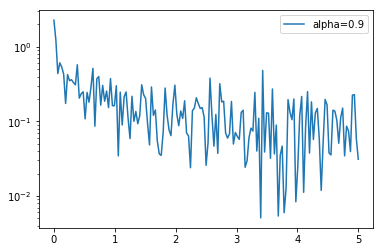

In [4]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='alpha=0.9')
plt.legend(loc='best')

In [5]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        rmsprop(net.parameters(), sqrs, 1e-3, 0.999) # 学习率设为 0.001，alpha 设为 0.999
        # 记录误差
        train_loss += loss.data[0]
        if idx % 30 == 0:
            losses.append(loss.data[0])
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.452672
epoch: 1, Train Loss: 0.175055
epoch: 2, Train Loss: 0.137153
epoch: 3, Train Loss: 0.114684
epoch: 4, Train Loss: 0.101455
使用时间: 64.16897 s


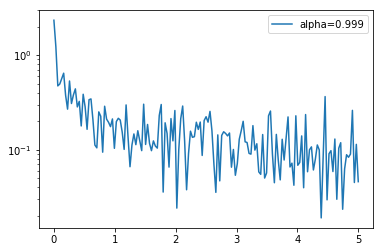

In [6]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='alpha=0.999')
plt.legend(loc='best')

**可以看到使用了不同的 alpha 会使得 loss 在下降过程中的震荡程度不同，想想为什么**

当然 pytorch 也内置了 rmsprop 的方法，非常简单，只需要调用 `torch.optim.RMSprop()` 就可以了，下面是例子

In [7]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, alpha=0.9)
    
# 开始训练

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data[0]
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.375323
epoch: 1, Train Loss: 0.171338
epoch: 2, Train Loss: 0.125839
epoch: 3, Train Loss: 0.103403
epoch: 4, Train Loss: 0.090435
使用时间: 70.40669 s
